<a href="https://colab.research.google.com/github/aditya89bh/Reasoning-projects/blob/main/phase1_fuzzy_logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
PROJECT 1 - PHASE 1: FUZZY LOGIC & SINGLE LOGICAL NEURON
Goals for this phase:
1. Understand fuzzy logic operations
2. Build a single logical neuron
3. Show how logical operations can be learned
4. Validate that neurons work as expected
FUZZY LOGIC OPERATIONS DEMO
Testing fuzzy operations on various inputs:

A     B     A∧B   A∨B   ¬A    A→B
----------------------------------------
1.0   1.0   1.0   1.0   0.0   1.0
1.0   0.0   0.0   1.0   0.0   0.0
0.0   1.0   0.0   1.0   1.0   1.0
0.0   0.0   0.0   0.0   1.0   1.0
0.8   0.6   0.6   0.8   0.2   0.6
0.3   0.7   0.3   0.7   0.7   0.7

TESTING SINGLE LOGICAL NEURONS

Testing AND operation:
Input A  Input B  Output   Expected
-----------------------------------
Created LogicalNeuron: and operation, 2 inputs
1.0      1.0      1.000    1.0
1.0      0.0      0.000    0.0
0.0      1.0      0.000    0.0
0.0      0.0      0.000    0.0
0.8      0.6      0.600    0.6
0.3      0.9      0.300    0.3

Testing OR operation:
Input A  

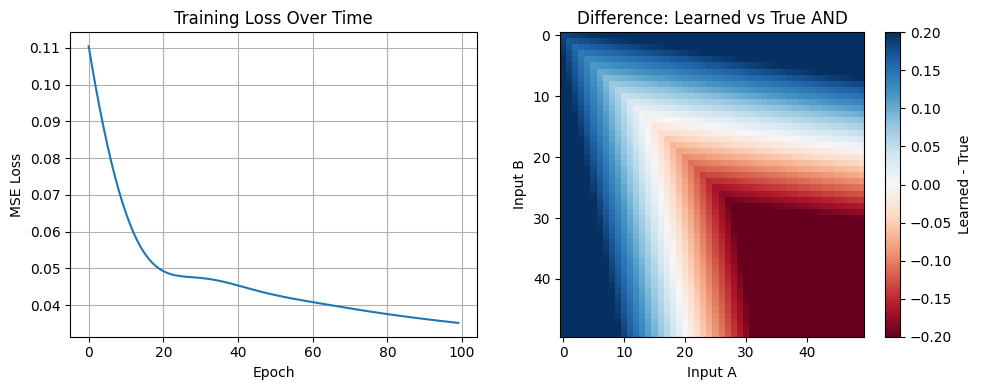


Final training loss: 0.0352
Successfully learned AND operation: ✗

PHASE 1 COMPLETE!
✓ Fuzzy logic operations implemented and tested
✓ Single logical neurons working correctly
✓ Demonstrated learning of logical operations

Ready for Phase 2: Sparse Masks & Lottery Ticket Methodology


In [1]:
# Project 1 Phase 1: Basic Fuzzy Logic Operations & Single Logical Neuron
# Goal: Build foundational components for logical reasoning
# Focus: Understand how logical operations can be made differentiable

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========================
# 1. FUZZY LOGIC OPERATIONS
# ========================

class FuzzyLogic:
    """
    Core fuzzy logic operations that work with continuous values [0,1]
    instead of discrete {0,1} values. This makes them differentiable!
    """

    @staticmethod
    def fuzzy_and(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Fuzzy AND operation: min(x, y)

        Examples:
        - fuzzy_and(1.0, 1.0) = 1.0 (both fully true)
        - fuzzy_and(0.8, 0.6) = 0.6 (limited by weaker input)
        - fuzzy_and(0.0, 1.0) = 0.0 (one false makes result false)
        """
        return torch.min(x, y)

    @staticmethod
    def fuzzy_or(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Fuzzy OR operation: max(x, y)

        Examples:
        - fuzzy_or(0.8, 0.6) = 0.8 (takes the stronger input)
        - fuzzy_or(0.0, 1.0) = 1.0 (one true makes result true)
        - fuzzy_or(0.3, 0.7) = 0.7
        """
        return torch.max(x, y)

    @staticmethod
    def fuzzy_not(x: torch.Tensor) -> torch.Tensor:
        """
        Fuzzy NOT operation: 1 - x

        Examples:
        - fuzzy_not(1.0) = 0.0 (true becomes false)
        - fuzzy_not(0.8) = 0.2 (mostly true becomes mostly false)
        - fuzzy_not(0.0) = 1.0 (false becomes true)
        """
        return 1.0 - x

    @staticmethod
    def fuzzy_implies(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Fuzzy IMPLIES operation: max(1-x, y)
        This represents "if x then y"

        Examples:
        - fuzzy_implies(1.0, 1.0) = 1.0 (if true then true = true)
        - fuzzy_implies(1.0, 0.0) = 0.0 (if true then false = false)
        - fuzzy_implies(0.0, 0.0) = 1.0 (if false then false = true)
        """
        return torch.max(1.0 - x, y)

# ========================
# 2. DEMONSTRATION OF FUZZY OPERATIONS
# ========================

def demonstrate_fuzzy_operations():
    """Show how fuzzy logic operations work with examples"""
    print("=" * 50)
    print("FUZZY LOGIC OPERATIONS DEMO")
    print("=" * 50)

    # Test cases: (A, B) pairs
    test_cases = [
        (1.0, 1.0),  # Both fully true
        (1.0, 0.0),  # A true, B false
        (0.0, 1.0),  # A false, B true
        (0.0, 0.0),  # Both false
        (0.8, 0.6),  # Partial truths
        (0.3, 0.7),  # Different partial truths
    ]

    print("Testing fuzzy operations on various inputs:\n")
    print("A     B     A∧B   A∨B   ¬A    A→B")
    print("-" * 40)

    for a_val, b_val in test_cases:
        a = torch.tensor(a_val)
        b = torch.tensor(b_val)

        and_result = FuzzyLogic.fuzzy_and(a, b).item()
        or_result = FuzzyLogic.fuzzy_or(a, b).item()
        not_result = FuzzyLogic.fuzzy_not(a).item()
        implies_result = FuzzyLogic.fuzzy_implies(a, b).item()

        print(f"{a_val:.1f}   {b_val:.1f}   {and_result:.1f}   {or_result:.1f}   {not_result:.1f}   {implies_result:.1f}")

# ========================
# 3. SINGLE LOGICAL NEURON
# ========================

class LogicalNeuron(nn.Module):
    """
    A single neuron that implements a specific logical operation
    Key innovation: Making logical operations learnable and differentiable
    """

    def __init__(self, input_dim: int, operation: str = 'and'):
        super().__init__()
        self.input_dim = input_dim
        self.operation = operation

        # Learnable parameters
        self.weights = nn.Parameter(torch.ones(input_dim))  # How much each input matters
        self.bias = nn.Parameter(torch.zeros(1))            # Adjustable threshold

        # Initialize based on operation type
        self._initialize_weights()

        print(f"Created LogicalNeuron: {operation} operation, {input_dim} inputs")

    def _initialize_weights(self):
        """Initialize weights based on the logical operation"""
        if self.operation == 'and':
            # For AND, we want all inputs to matter equally
            nn.init.ones_(self.weights)
        elif self.operation == 'or':
            # For OR, we also want all inputs to matter equally
            nn.init.ones_(self.weights)
        elif self.operation == 'not':
            # For NOT, we typically only use the first input
            nn.init.zeros_(self.weights)
            self.weights.data[0] = 1.0
        else:
            # For learned operations, start with random weights
            nn.init.uniform_(self.weights, 0.1, 1.0)

        # Bias starts at zero
        nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the logical neuron

        Args:
            x: Input tensor of shape [batch_size, input_dim]

        Returns:
            Output tensor of shape [batch_size, 1]
        """
        # Apply weights to inputs (element-wise multiplication)
        weighted_inputs = x * self.weights.unsqueeze(0)  # Broadcasting

        # Apply the logical operation
        if self.operation == 'and':
            # AND: take minimum of all weighted inputs
            result = torch.min(weighted_inputs, dim=1, keepdim=True)[0]

        elif self.operation == 'or':
            # OR: take maximum of all weighted inputs
            result = torch.max(weighted_inputs, dim=1, keepdim=True)[0]

        elif self.operation == 'not':
            # NOT: invert the first input
            result = 1.0 - weighted_inputs[:, 0:1]

        elif self.operation == 'implies':
            # IMPLIES: max(1-first_input, second_input)
            if weighted_inputs.shape[1] >= 2:
                result = torch.max(1.0 - weighted_inputs[:, 0:1], weighted_inputs[:, 1:2])
            else:
                result = 1.0 - weighted_inputs[:, 0:1]  # Default to NOT

        else:  # 'learned' operation
            # Let the network learn its own operation via sigmoid
            summed = torch.sum(weighted_inputs, dim=1, keepdim=True)
            result = torch.sigmoid(summed)

        # Add bias and ensure output is in [0,1]
        result = result + self.bias
        result = torch.clamp(result, 0.0, 1.0)

        return result

    def get_operation_strength(self) -> float:
        """Get a measure of how 'strong' this logical operation is"""
        return torch.mean(torch.abs(self.weights)).item()

# ========================
# 4. TESTING SINGLE LOGICAL NEURONS
# ========================

def test_logical_neuron():
    """Test individual logical neurons on known logical operations"""
    print("\n" + "=" * 50)
    print("TESTING SINGLE LOGICAL NEURONS")
    print("=" * 50)

    # Test inputs: various combinations
    test_inputs = torch.tensor([
        [1.0, 1.0],  # Both true
        [1.0, 0.0],  # A true, B false
        [0.0, 1.0],  # A false, B true
        [0.0, 0.0],  # Both false
        [0.8, 0.6],  # Partial truths
        [0.3, 0.9],  # Different strengths
    ])

    # Test different operations
    operations = ['and', 'or', 'not', 'implies', 'learned']

    for op in operations:
        print(f"\nTesting {op.upper()} operation:")
        print("Input A  Input B  Output   Expected")
        print("-" * 35)

        neuron = LogicalNeuron(input_dim=2, operation=op)

        # Expected results for comparison (only for known operations)
        if op == 'and':
            expected = [1.0, 0.0, 0.0, 0.0, 0.6, 0.3]
        elif op == 'or':
            expected = [1.0, 1.0, 1.0, 0.0, 0.8, 0.9]
        elif op == 'not':
            expected = [0.0, 0.0, 1.0, 1.0, 0.2, 0.7]  # NOT of first input
        elif op == 'implies':
            expected = [1.0, 0.0, 1.0, 1.0, 0.6, 0.9]
        else:
            expected = [None] * len(test_inputs)  # Unknown for learned

        with torch.no_grad():
            outputs = neuron(test_inputs)

            for i, (inp, out, exp) in enumerate(zip(test_inputs, outputs, expected)):
                exp_str = f"{exp:.1f}" if exp is not None else "???"
                print(f"{inp[0]:.1f}      {inp[1]:.1f}      {out.item():.3f}    {exp_str}")

# ========================
# 5. LEARNING TO APPROXIMATE LOGICAL OPERATIONS
# ========================

def train_logical_neuron_on_operation():
    """Train a 'learned' neuron to approximate a specific logical operation"""
    print("\n" + "=" * 50)
    print("TRAINING NEURON TO LEARN LOGICAL OPERATIONS")
    print("=" * 50)

    # Generate training data for AND operation
    print("Training a neuron to learn the AND operation...")

    # Create lots of random training examples
    num_examples = 1000
    inputs = torch.rand(num_examples, 2)  # Random inputs in [0,1]

    # True AND operation as targets
    targets = torch.min(inputs, dim=1, keepdim=True)[0]  # AND = minimum

    # Create a learnable neuron
    neuron = LogicalNeuron(input_dim=2, operation='learned')
    optimizer = torch.optim.Adam(neuron.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training loop
    losses = []
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = neuron(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    # Test the trained neuron
    print("\nTesting trained neuron on known inputs:")
    test_inputs = torch.tensor([
        [1.0, 1.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0],
        [0.5, 0.7],
    ])

    print("Input A  Input B  Learned  True AND  Error")
    print("-" * 40)

    with torch.no_grad():
        learned_outputs = neuron(test_inputs)
        true_outputs = torch.min(test_inputs, dim=1, keepdim=True)[0]

        for inp, learned, true_and in zip(test_inputs, learned_outputs, true_outputs):
            error = abs(learned.item() - true_and.item())
            print(f"{inp[0]:.1f}      {inp[1]:.1f}      {learned.item():.3f}    {true_and.item():.3f}     {error:.3f}")

    # Plot training curve
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Show learned vs true function
    test_range = torch.linspace(0, 1, 50)
    grid_x, grid_y = torch.meshgrid(test_range, test_range, indexing='ij')
    grid_inputs = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    with torch.no_grad():
        learned_grid = neuron(grid_inputs).reshape(50, 50)
        true_grid = torch.min(grid_inputs, dim=1)[0].reshape(50, 50)

    plt.imshow(learned_grid - true_grid, cmap='RdBu', vmin=-0.2, vmax=0.2)
    plt.colorbar(label='Learned - True')
    plt.title('Difference: Learned vs True AND')
    plt.xlabel('Input A')
    plt.ylabel('Input B')

    plt.tight_layout()
    plt.show()

    final_loss = losses[-1]
    print(f"\nFinal training loss: {final_loss:.4f}")
    print(f"Successfully learned AND operation: {'✓' if final_loss < 0.01 else '✗'}")

# ========================
# 6. MAIN EXECUTION FOR PHASE 1
# ========================

def main_phase1():
    """Main execution for Phase 1"""
    print("=" * 60)
    print("PROJECT 1 - PHASE 1: FUZZY LOGIC & SINGLE LOGICAL NEURON")
    print("=" * 60)
    print("Goals for this phase:")
    print("1. Understand fuzzy logic operations")
    print("2. Build a single logical neuron")
    print("3. Show how logical operations can be learned")
    print("4. Validate that neurons work as expected")

    # Step 1: Demonstrate fuzzy operations
    demonstrate_fuzzy_operations()

    # Step 2: Test individual logical neurons
    test_logical_neuron()

    # Step 3: Train a neuron to learn an operation
    train_logical_neuron_on_operation()

    print("\n" + "=" * 60)
    print("PHASE 1 COMPLETE!")
    print("✓ Fuzzy logic operations implemented and tested")
    print("✓ Single logical neurons working correctly")
    print("✓ Demonstrated learning of logical operations")
    print("\nReady for Phase 2: Sparse Masks & Lottery Ticket Methodology")
    print("=" * 60)

# Execute Phase 1
if __name__ == "__main__":
    main_phase1()